# Look at the bottom pressure recorder data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from s3fs import S3FileSystem, S3Map

import cmocean as cm

/opt/tljh/user/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
%matplotlib notebook

In [3]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'


In [4]:
ds = xr.open_dataset('../DATA/[BB23]_[BB23_REC]_[W310]_[48]_[RBRquartz TP]_[213895]_[no_outfile_append].nc')
ds

<xarray.Dataset>
Dimensions:          (time: 9676801)
Coordinates:
  * time             (time) datetime64[ns] 2023-05-07 ... 2023-05-14
    lat_nom          float64 ...
    lon_nom          float64 ...
    z_nom            float64 ...
Data variables:
    BPR_Pressure     (time) float64 ...
    Temperature      (time) float64 ...
    BPR_Temperature  (time) float64 ...
    qc_Temperature   (time) float64 ...
    qc_Pressure      (time) float64 ...
Attributes: (12/34)
    title:                           Measured data from an RBR Data Logger
    institution:                     The University of Western Australia
    institution_division:            Ocean Dynamics
    source:                          RBR Data Logger
    project:                         BB23
    history:                         
    ...                              ...
    pressure_sensor_height_asb:      
    nominal_instrument_height_asb:   0.48
    nominal_instrument_orientation:  
    timezone:                        UTC
    process_level:                   
    is_profile_data:                 0

<IPython.core.display.Javascript object>


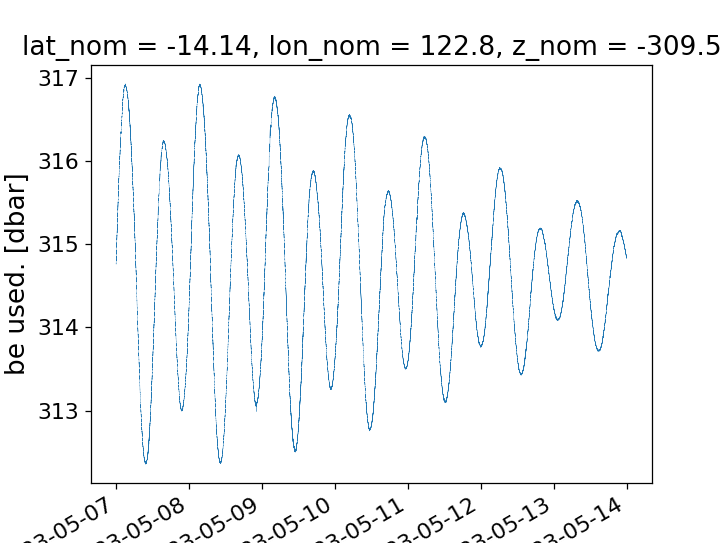

In [5]:
plt.figure()
ds['BPR_Pressure'].plot(lw=0.2)

In [6]:
from scipy import signal

def filt(ytmp, cutoff_dt, dt, btype='low', order=8, ftype='sos', axis=-1):
    """
    Butterworth filter the time series

    Inputs:
        cutoff_dt - cuttoff period [seconds]
        btype - 'low' or 'high' or 'band'
    """
    if not btype == 'band':
        Wn = dt/cutoff_dt
    else:
        Wn = [dt/co for co in cutoff_dt]
    
    if ftype=='sos':
        sos = signal.butter(order, Wn, btype, analog=False, output='sos')
        return signal.sosfiltfilt(sos, ytmp, axis=axis)
    else:
        (b, a) = signal.butter(order, Wn, btype=btype, analog=0, output='ba')
        return signal.filtfilt(b, a, ytmp, axis=axis)


def filt_decompose(xraw, dt, b1=34*3600, b2=4*3600):
    x1 = filt(xraw,b1, dt, btype='low')
    x2 = filt(xraw, [b1,b2], dt, btype='band')
    x3 = filt(xraw, b2, dt, btype='high')
    
    xin = np.vstack([x1,x2,x3]).T
    
    return xin



In [7]:
time = ds.time.values
dt = (time[1:]-time[:-1]).mean()
dtsec = dt.astype(float)*1e-9
dtsec, 1/dtsec

(0.0625, 16.0)

In [8]:
yf = filt_decompose(ds['BPR_Pressure']-ds['BPR_Pressure'].mean(), dtsec)


<IPython.core.display.Javascript object>


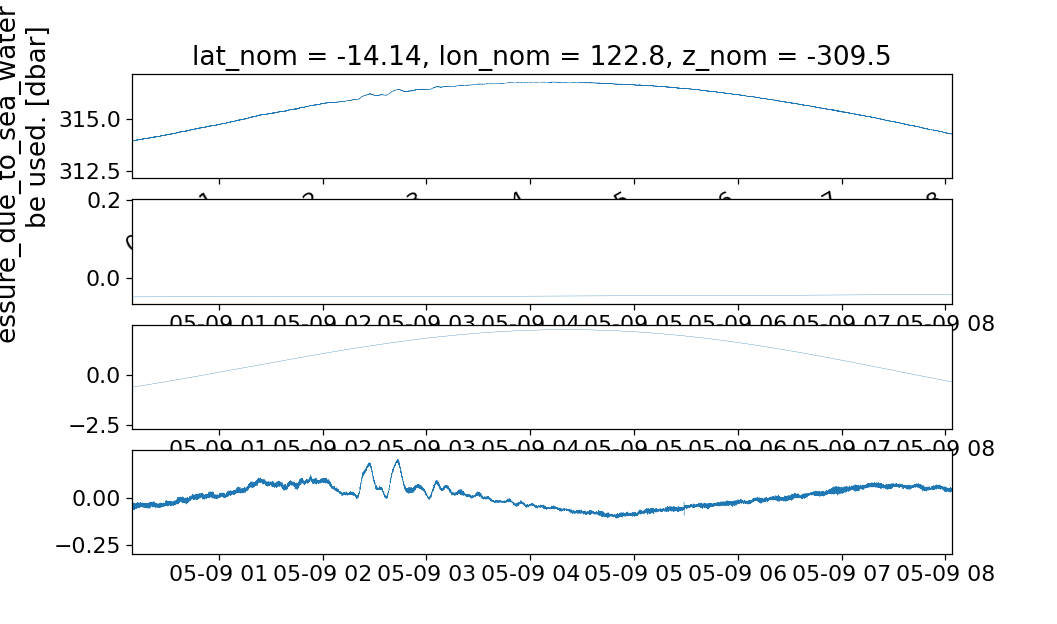

In [9]:
plt.figure()

ax0 = plt.subplot(411)
ds['BPR_Pressure'].plot(lw=0.2)

ax1 = plt.subplot(412,sharex=ax0)
plt.plot(time, yf[:,0], lw=0.2)

ax2 = plt.subplot(413,sharex=ax0)
plt.plot(time, yf[:,1], lw=0.2)

ax3 = plt.subplot(414, sharex=ax0)
plt.plot(time, yf[:,2], lw=0.2)

